In [14]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

In [143]:
normalize([1,2,3])

array([ 0.,  1.,  2.])

In [144]:
normalize(4, 1)

3.0

In [140]:
def normalize(array, startprice=None):
    ''' go from stock price to return; if no startprice given, assume first entry '''
    array = np.array(array)
    init = startprice if startprice is not None else array[0]
    return (array/init) - 1

def denormalize(array, startprice):
    ''' go from return on investment to stock price '''
    return startprice*(array+1)

def load_stock(colnum=1, lookback=50, shuffle_train=True, filename='stocks.csv'):
    ''' load training and test data for a specific stock '''
    data = pd.read_csv('stocks.csv', usecols=[colnum]).values[:,0]
    X_train, y_train, X_valid, y_valid, X_test, y_test = [], [], [], [], [], []
    for i in range(data.shape[0]-lookback):
        x_curr, y_curr = normalize(data[i:i+lookback]), normalize(data[i+lookback], data[i])
        if i < .6*(data.shape[0]-lookback): #training set, 60%
            X_train.append(x_curr)
            y_train.append(y_curr)
        elif i < .8*(data.shape[0]-lookback): #validation set, 20%
            X_valid.append(x_curr)
            y_valid.append(y_curr)
        else: #test set, 20%
            X_test.append(x_curr)
            y_test.append(y_curr)
    if shuffle_train: #shuffle training set
        idx = range(len(X_train))
        np.random.shuffle(idx)
        X_train = np.array(X_train)[idx,:]
        y_train = np.array(y_train)[idx]
    return np.array(X_train), np.array(y_train), \
           np.array(X_valid), np.array(y_valid), \
           np.array(X_test), np.array(y_test)

# load practice stock, AAPL
lookback = 50
X_train, y_train, X_valid, y_valid, X_test, y_test = load_stock(colnum=1, lookback=lookback, shuffle_train=False)

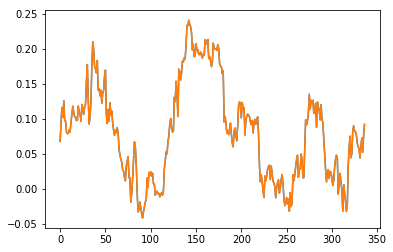

In [146]:
plt.plot(y_test)
plt.show()

In [142]:
y_train

array([ 0.00133509,  0.01011193, -0.0099701 , ...,  0.16844549,
        0.13692019,  0.13105972])

In [141]:
X_train

array([[ 0.        ,  0.00521896,  0.01344178, ...,  0.06802803,
         0.07279182,  0.04812326],
       [ 0.        ,  0.00818013,  0.00736508, ...,  0.06722204,
         0.04268155, -0.0038637 ],
       [ 0.        , -0.00080844,  0.00634728, ...,  0.03422149,
        -0.01194611,  0.00191613],
       ..., 
       [ 0.        ,  0.03842226,  0.03953598, ...,  0.17902553,
         0.19229699,  0.18329466],
       [ 0.        ,  0.00107251, -0.02359459, ...,  0.14818127,
         0.13951203,  0.12521229],
       [ 0.        , -0.02464067, -0.01598072, ...,  0.1382912 ,
         0.12400678,  0.13570214]])

In [134]:
# build model
model = Sequential()
model.add(LSTM(input_shape=(None,1), units=lookback, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.add(Activation('linear'))
model.compile(loss='mse', optimizer='rmsprop')

In [136]:
# fit model
model.fit(
    X_train.reshape(X_train.shape[0],X_train.shape[1],1),
    y_train,
    batch_size=512,
    nb_epoch=10,
    validation_split=0.05)

Train on 961 samples, validate on 51 samples
Epoch 1/10
961/961 [==============================] - 1s 1ms/step - loss: 5477.7770 - val_loss: 13690.3232
Epoch 2/10
961/961 [==============================] - 1s 1ms/step - loss: 5137.5820 - val_loss: 13253.0664
Epoch 3/10
961/961 [==============================] - 1s 1ms/step - loss: 4886.3632 - val_loss: 12859.2031
Epoch 4/10
961/961 [==============================] - 1s 1ms/step - loss: 4671.1126 - val_loss: 12521.5283
Epoch 5/10
961/961 [==============================] - 1s 1ms/step - loss: 4484.1795 - val_loss: 12247.6436
Epoch 6/10
961/961 [==============================] - 1s 1ms/step - loss: 4330.3511 - val_loss: 12045.8203
Epoch 7/10
961/961 [==============================] - 1s 1ms/step - loss: 4225.8960 - val_loss: 11909.2598
Epoch 8/10
961/961 [==============================] - 1s 1ms/step - loss: 4155.8110 - val_loss: 11802.3447
Epoch 9/10
961/961 [==============================] - 1s 1ms/step - loss: 4089.9427 - val_loss: 117